### Nama : AARON WINSTON GHO
### NIM : 2702210522

# 2A Datasets About diseases called Brain Tumor

Information About The Datasets:
It's a datasets that consists of training and testing folder where each folder there are 4 type of disease, glioma, Meningioma, notumor, pituitary

Main Goals Of the Datasets:
multiclassification where we need to clasify disease, where which disease is glioma, meningioma,notumor,pituitary

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


# Importing Library

In [44]:
import matplotlib.pyplot as plt

import os

import pandas as pd
import numpy as np
from collections import defaultdict
import random
from PIL import Image
from datetime import datetime
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image, ImageOps
import shutil
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0,DenseNet121,MobileNetV2,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
import zipfile
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from itertools import combinations

SEED_VALUE = 1234
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
tf.config.set_visible_devices([], 'GPU')

# EDA & Preprocessing

### Read The Dataset

for the first thing that we need to do is extract the zip file so we can easily see and read each training and testing data

In [26]:
zip_path = '/content/Dataset 2A.zip'
extract_dir = '/content/extracted_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("File yang berhasil di-extract:")
for file in os.listdir(extract_dir):
    print("-", file)

File yang berhasil di-extract:
- Dataset 2A
- __MACOSX


because i use macos there's two type of files that got extracted but no worries we'll deleted/drop the macos one latter.

first thing first lets make a function to see this 4 things for eda as pak greg told us so:
1. count the file number and the extension ( the extension needs to be jpg or png to be train and test)
2. change the file size to default (224x224) if it isn't
3. Ratio of the picture needs to be 1:1
4. check the classes and the count for each class.

In [6]:
def image_dataset_eda(folder_path):
    file_types = defaultdict(int)
    resolutions = defaultdict(int)
    aspect_ratios = defaultdict(int)
    category_count = defaultdict(int)
    image_info = []
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        category_count[class_name] += 1
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            ext = fname.split('.')[-1].lower()
            if ext not in ['jpg', 'jpeg', 'png']:
                continue
            try:
                img = Image.open(fpath)
                width, height = img.size

                file_types[ext] += 1
                resolutions[f"{width}x{height}"] += 1
                ratio = round(width / height, 2)
                aspect_ratios[ratio] += 1
                image_info.append({
                    "Filename": fname,
                    "Category": class_name,
                    "Extension": ext,
                    "Width": width,
                    "Height": height,
                    "Aspect Ratio": ratio
                })
            except Exception as e:
                print(f"Gagal baca {fpath}: {e}")
    df = pd.DataFrame(image_info)
    print("Jumlah file per ekstensi:")
    for k, v in file_types.items():
        print(f"  - .{k}: {v} file")
    print("Resolusi yang paling sering muncul:")
    for k, v in sorted(resolutions.items(), key=lambda x: -x[1])[:5]:
        print(f"  - {k}: {v} gambar")
    print("Rasio aspek (lebar/tinggi) yang umum:")
    for k, v in sorted(aspect_ratios.items(), key=lambda x: -x[1])[:5]:
        print(f"  - {k}: {v} gambar")
    print("\nJumlah kategori:")
    for k, v in category_count.items():
        print(f"  - {k}: {v} gambar")
    return df

In [7]:
df_eda = image_dataset_eda("extracted_data/Dataset 2A/Training")

Jumlah file per ekstensi:
  - .jpg: 5712 file
Resolusi yang paling sering muncul:
  - 512x512: 3955 gambar
  - 225x225: 268 gambar
  - 630x630: 77 gambar
  - 236x236: 53 gambar
  - 201x251: 43 gambar
Rasio aspek (lebar/tinggi) yang umum:
  - 1.0: 4525 gambar
  - 0.8: 108 gambar
  - 1.03: 83 gambar
  - 0.86: 60 gambar
  - 0.76: 52 gambar

Jumlah kategori:
  - notumor: 1 gambar
  - glioma: 1 gambar
  - meningioma: 1 gambar
  - pituitary: 1 gambar


so here we can see that all of the extension is jpg so thats a good thing but we still need to drop the mac.os one remember. next we see that the size is not yet 224 x 224 (default size) so we need to change the size to default size. Lastly for the ratio we need to make 1:1 to be processed later. Also we can see that there is 4 class.

### Validating Datasets

so here i made a function just to validate which wrong with our data. In the last section we know that our data has some problem issues with the ratio. SO here's lets validate for each folder.

In [8]:
def validate_images(directory, target_size=(224, 224), allowed_extensions=('.jpg', '.png')):
    valid_count = 0
    resize_count = 0
    invalid_files = []

    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)

            if not file.lower().endswith(allowed_extensions):
                invalid_files.append((file, "Invalid extension"))
                continue

            try:
                with Image.open(filepath) as img:
                    if img.width != img.height:
                        invalid_files.append((file, f"Aspect ratio not 1:1 ({img.width}x{img.height})"))
                        continue

                    if img.size != target_size:
                        resize_count += 1

                    valid_count += 1

            except Exception as e:
                invalid_files.append((file, f"Corrupted image: {str(e)}"))

    print(f"Validation Results for {directory}:")
    print(f"- Valid images: {valid_count}")
    print(f"- Images needing resize: {resize_count}")
    print(f"- Invalid files: {len(invalid_files)}")

    if invalid_files:
        print("\nInvalid files details:")
        for file, reason in invalid_files[:10]:
            print(f"{file}: {reason}")

    return valid_count, resize_count, invalid_files

to make sure lets validate the datasets once more is it really true all is jpg or there is a hidden extension there

In [9]:
valid_count, resize_count, invalid_files = validate_images("extracted_data/Dataset 2A/Testing")

Validation Results for extracted_data/Dataset 2A/Testing:
- Valid images: 921
- Images needing resize: 921
- Invalid files: 391

Invalid files details:
.DS_Store: Invalid extension
Te-no_0371.jpg: Aspect ratio not 1:1 (300x168)
Te-no_0235.jpg: Aspect ratio not 1:1 (420x280)
Te-no_0207.jpg: Aspect ratio not 1:1 (227x222)
Te-no_0338.jpg: Aspect ratio not 1:1 (215x234)
Te-no_0104.jpg: Aspect ratio not 1:1 (236x251)
Te-no_0226.jpg: Aspect ratio not 1:1 (468x444)
Te-no_0351.jpg: Aspect ratio not 1:1 (206x244)
Te-no_0354.jpg: Aspect ratio not 1:1 (504x540)
Te-no_0303.jpg: Aspect ratio not 1:1 (200x252)


In [10]:
valid_count, resize_count, invalid_files = validate_images("extracted_data/Dataset 2A/Training")

Validation Results for extracted_data/Dataset 2A/Training:
- Valid images: 4494
- Images needing resize: 4494
- Invalid files: 1219

Invalid files details:
.DS_Store: Invalid extension
Tr-no_1196.jpg: Aspect ratio not 1:1 (359x449)
Tr-no_1345.jpg: Aspect ratio not 1:1 (206x244)
Tr-no_0801.jpg: Aspect ratio not 1:1 (550x664)
Tr-no_0751.jpg: Aspect ratio not 1:1 (550x664)
Tr-no_1266.jpg: Aspect ratio not 1:1 (300x168)
Tr-no_1512.jpg: Aspect ratio not 1:1 (227x222)
Tr-no_1050.jpg: Aspect ratio not 1:1 (331x406)
Tr-no_1224.jpg: Aspect ratio not 1:1 (228x221)
Tr-no_0785.jpg: Aspect ratio not 1:1 (428x417)


as we can see that pesky ds.store we'll drop it soon and clear the rest

### Converting JPG and Size

after we already know the problem, the invalid files, we're gonaa converting the jpeg,png,video to jpg and for the size we're using the default 224x224 which automatically change the ratio to 1:1.

In [11]:
def convert_images_to_224_and_jpg(folder_path):
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue

        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            name, ext = os.path.splitext(fname)
            ext = ext.lower()

            if ext not in [".jpg", ".jpeg", ".png"]:
                continue

            try:
                img = Image.open(fpath).convert('RGB')
                img = img.resize((224, 224))

                new_name = f"{name}.jpg"
                new_path = os.path.join(class_path, new_name)
                img.save(new_path, "JPEG")

                if ext != ".jpg":
                    os.remove(fpath)

            except Exception as e:
                print(f"Gagal proses {fpath}: {e}")

In [12]:
convert_images_to_224_and_jpg("extracted_data/Dataset 2A/Training")
convert_images_to_224_and_jpg("extracted_data/Dataset 2A/Testing")

so here after we convert we need to delete the macosx data files that is .DS_STORE, or not it could affect our training later.

In [13]:
def force_drop_invalid_files(folder_path, valid_exts=[".jpg", ".jpeg", ".png"]):
    for root, _, files in os.walk(folder_path):
        for fname in files:
            fpath = os.path.join(root, fname)
            _, ext = os.path.splitext(fname)
            ext = ext.lower()

            if ext not in valid_exts or fname.startswith('.'):
                try:
                    os.remove(fpath)
                    print(f"Deleted: {fpath}")
                except Exception as e:
                    print(f"Failed to delete {fpath}: {e}")

In [14]:
force_drop_invalid_files("extracted_data/Dataset 2A/Training")

Deleted: extracted_data/Dataset 2A/Training/.DS_Store


In [15]:
force_drop_invalid_files("extracted_data/Dataset 2A/Testing")

Deleted: extracted_data/Dataset 2A/Testing/.DS_Store


final checking for each folder and we can see that is very clean now so lets move on to visualization

In [16]:
valid_count, resize_count, invalid_files = validate_images("extracted_data/Dataset 2A/Training")

Validation Results for extracted_data/Dataset 2A/Training:
- Valid images: 5712
- Images needing resize: 0
- Invalid files: 0


In [17]:
valid_count, resize_count, invalid_files = validate_images("extracted_data/Dataset 2A/Testing")

Validation Results for extracted_data/Dataset 2A/Testing:
- Valid images: 1311
- Images needing resize: 0
- Invalid files: 0


before splitting lets make tensorflow datasets for train dan val which we are gonna use later on in our training model. here validation ratio is 0.15 just like the question wants us to do.

In [30]:
Dataset_path = "extracted_data/Dataset 2A"

image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(Dataset_path,"Training"),
    validation_split=0.15,
    label_mode = "categorical",
    subset="training",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(Dataset_path,"Training"),
    validation_split=0.15,
    label_mode = "categorical",
    subset="validation",
    seed=SEED_VALUE,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5712 files belonging to 4 classes.
Using 4856 files for training.
Found 5712 files belonging to 4 classes.
Using 856 files for validation.


checking classes

In [ ]:
train_ds.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

overview picture per class names (just one)

tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


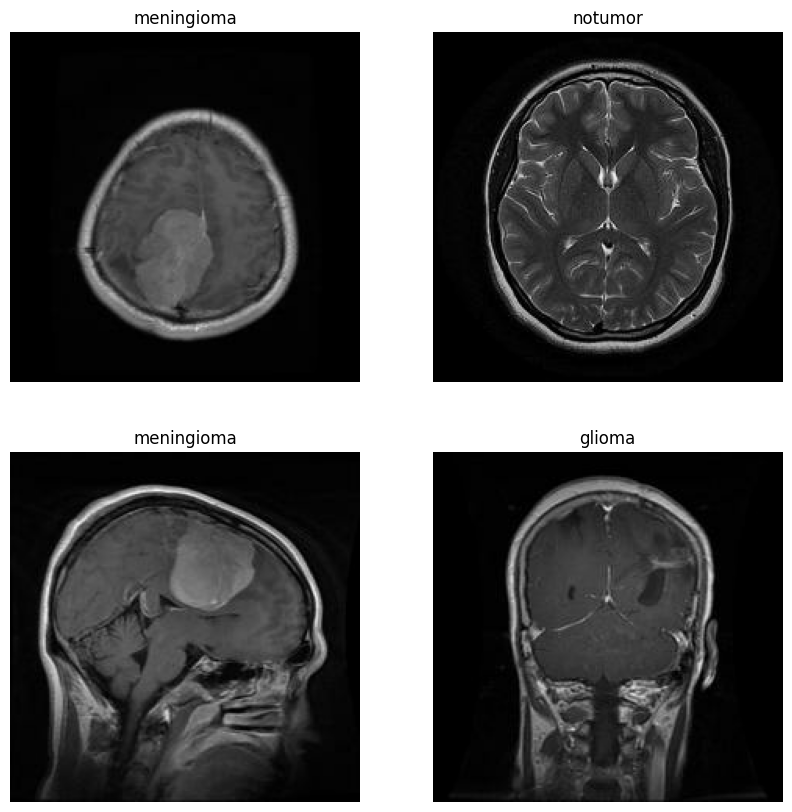

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(len(images)):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(labels[i])
        plt.title(train_ds.class_names[int(np.argmax(labels[i].numpy()).astype("uint8"))])
        plt.axis("off")

more visualization, so here we are making a function for the distribution, the function consists of:
1. class distribution count ( not in graph )
2. RGB distribution each classes
3. 5 samples for each classes

In [ ]:
def analyze_distribution(directory, sample_size=5):
    class_counts = defaultdict(int)
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))

    print("\nClass Distribution:")
    df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
    print(df)

    print("\nRGB Channel Distribution per Class:")
    plt.figure(figsize=(15, 5))

    for i, class_name in enumerate(class_counts.keys()):
        class_dir = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png'))]

        if not image_files:
            continue

        sample_files = random.sample(image_files, min(10, len(image_files)))
        rgb_values = {'Red': [], 'Green': [], 'Blue': []}

        for file in sample_files:
            img = Image.open(os.path.join(class_dir, file))  # Now properly imported
            img_array = np.array(img)

            if len(img_array.shape) == 3:
                rgb_values['Red'].append(np.mean(img_array[:, :, 0]))
                rgb_values['Green'].append(np.mean(img_array[:, :, 1]))
                rgb_values['Blue'].append(np.mean(img_array[:, :, 2]))

        plt.subplot(1, len(class_counts), i+1)
        plt.bar(rgb_values.keys(), [np.mean(rgb_values[c]) for c in rgb_values])
        plt.title(f"Class: {class_name}")
        plt.ylim(0, 255)

    plt.suptitle('Average RGB Channel Values per Class')
    plt.show()

    print("\nSample Images from Each Class:")
    plt.figure(figsize=(15, 3*sample_size))

    for i, class_name in enumerate(class_counts.keys()):
        class_dir = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png'))]

        if not image_files:
            continue

        sample_files = random.sample(image_files, min(sample_size, len(image_files)))

        for j, file in enumerate(sample_files):
            img = Image.open(os.path.join(class_dir, file))

            plt.subplot(len(class_counts), sample_size, i*sample_size + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}\n{img.size[0]}x{img.size[1]}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()


Class Distribution:
            Count
meningioma   1339
glioma       1321
notumor      1595
pituitary    1457

RGB Channel Distribution per Class:


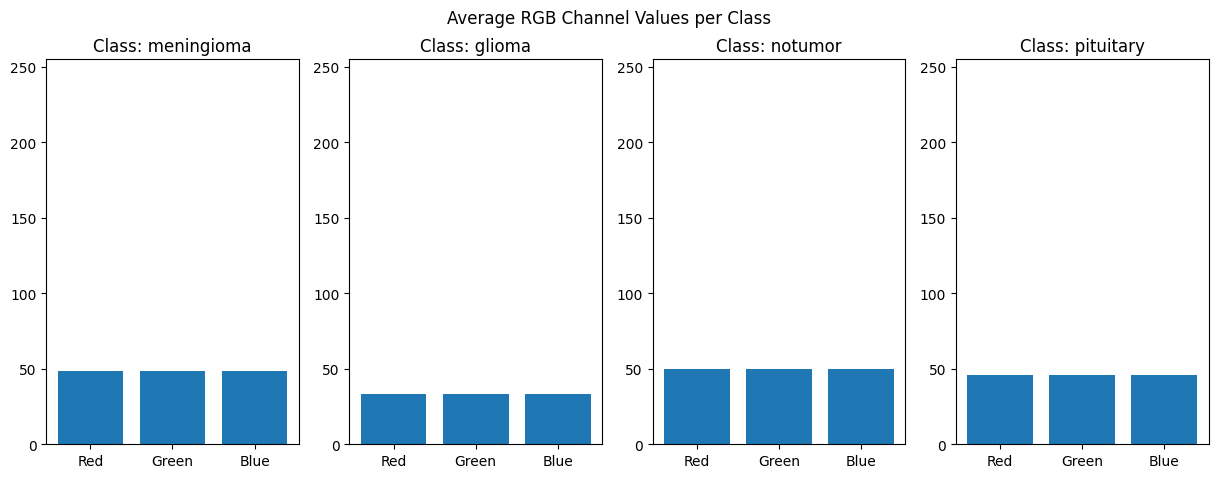


Sample Images from Each Class:


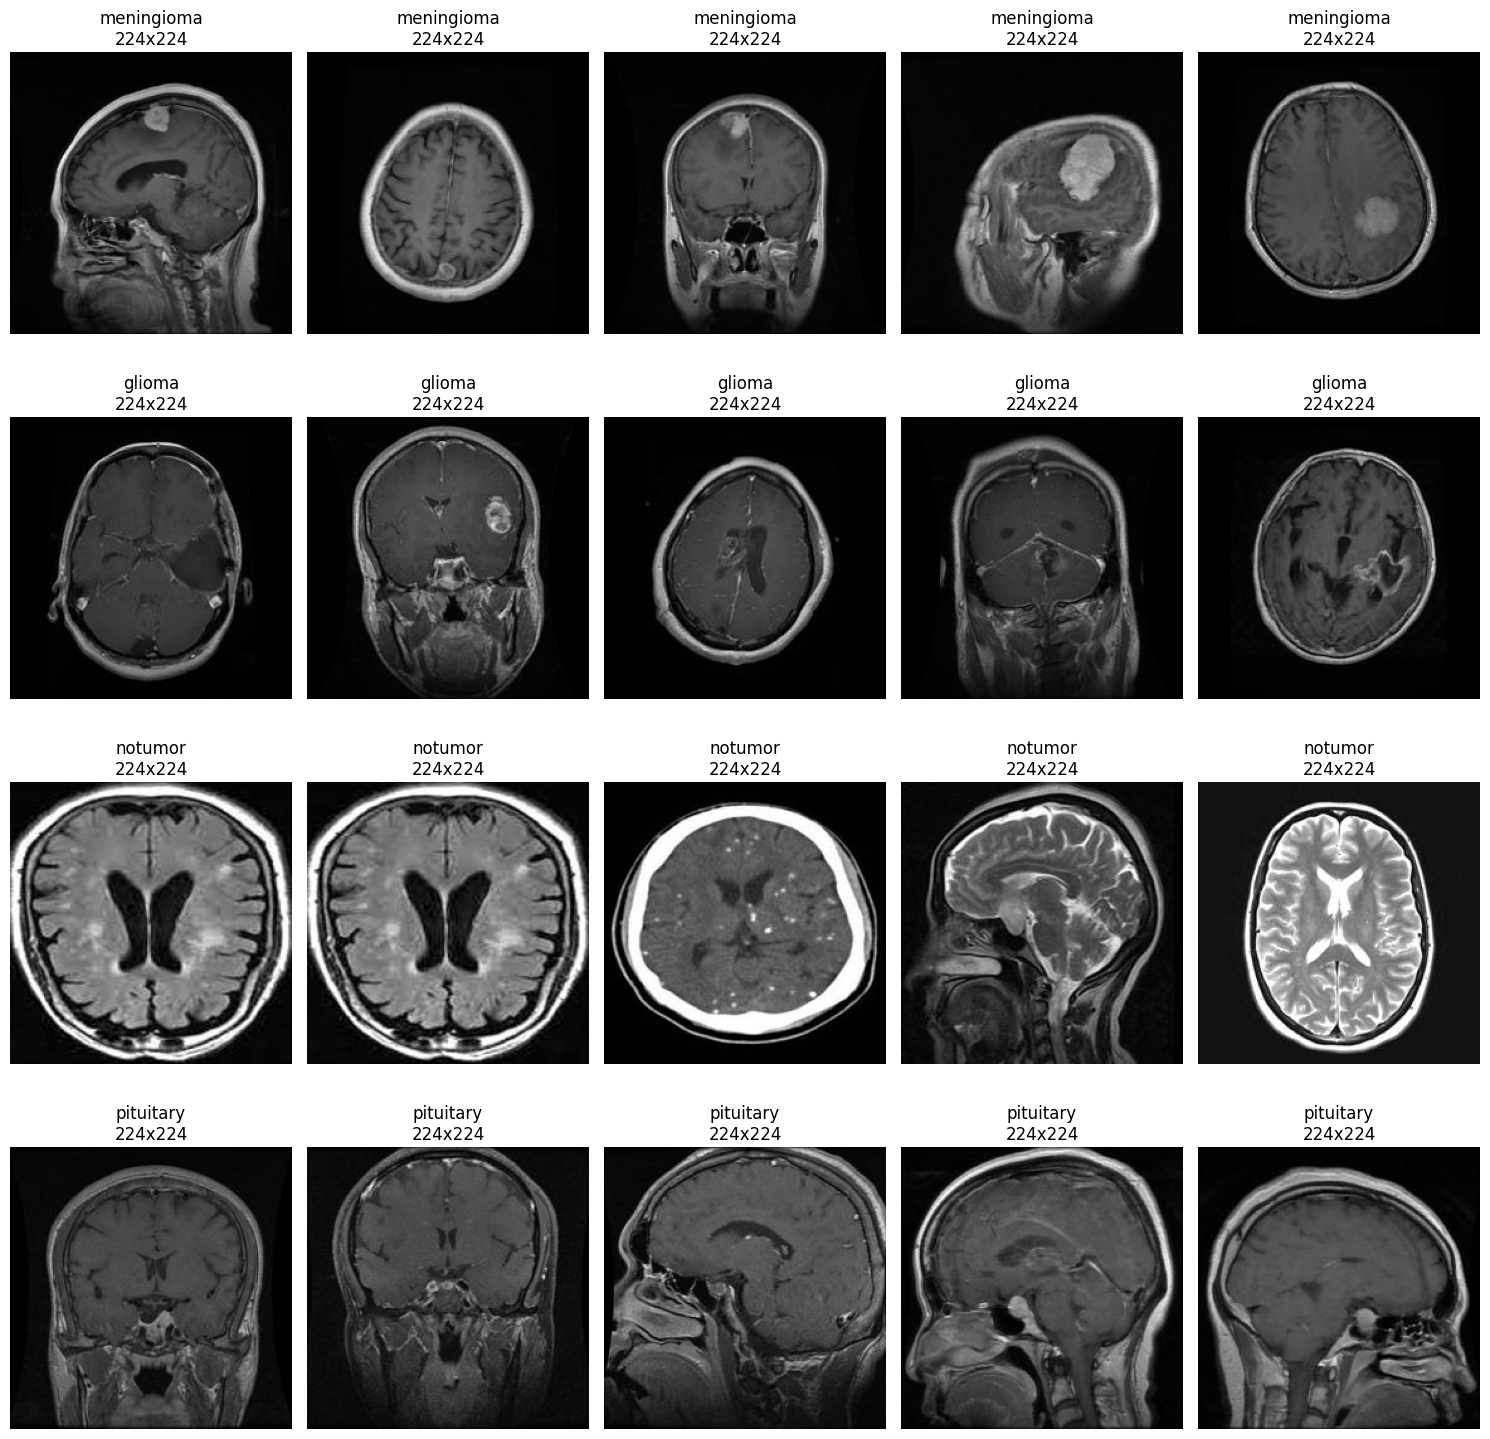

In [ ]:
analyze_distribution("extracted_data/Dataset 2A/Training")

so here's theirs an interesting thing
1. from the count distribution we can say that it's very well distributed, we can see that each distribution doesnt have a huge gap (maximum at 200) so here we can see that the most training data is for notumor ( normal guys )
2. for the rgb there is something that catches me, and that is each RGB classes which red, green and blue has the same amount mean per classes.
3. samples are normal (emote thumbs up)


Class Distribution:
            Count
meningioma    306
glioma        300
notumor       405
pituitary     300

RGB Channel Distribution per Class:


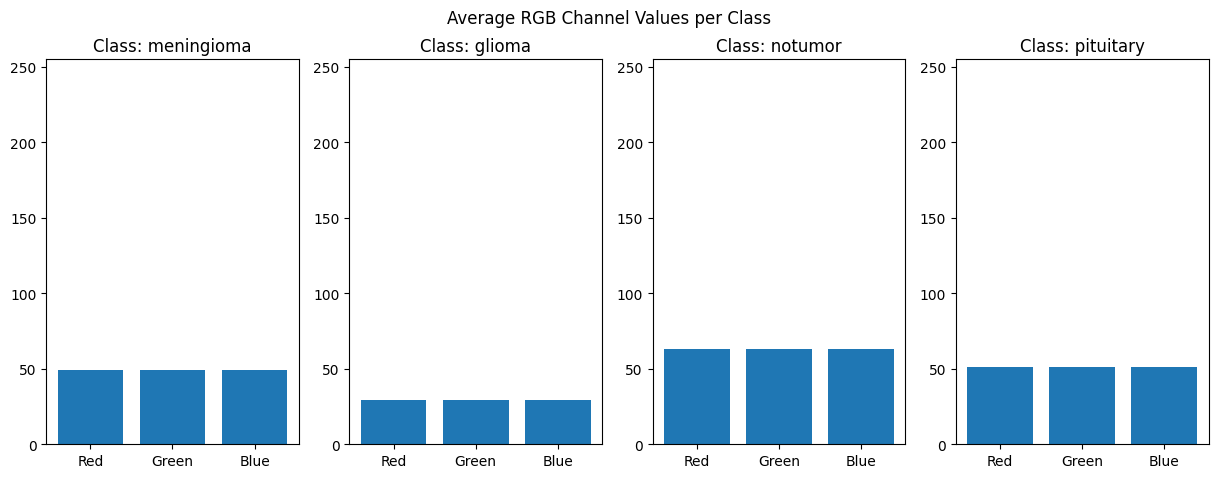


Sample Images from Each Class:


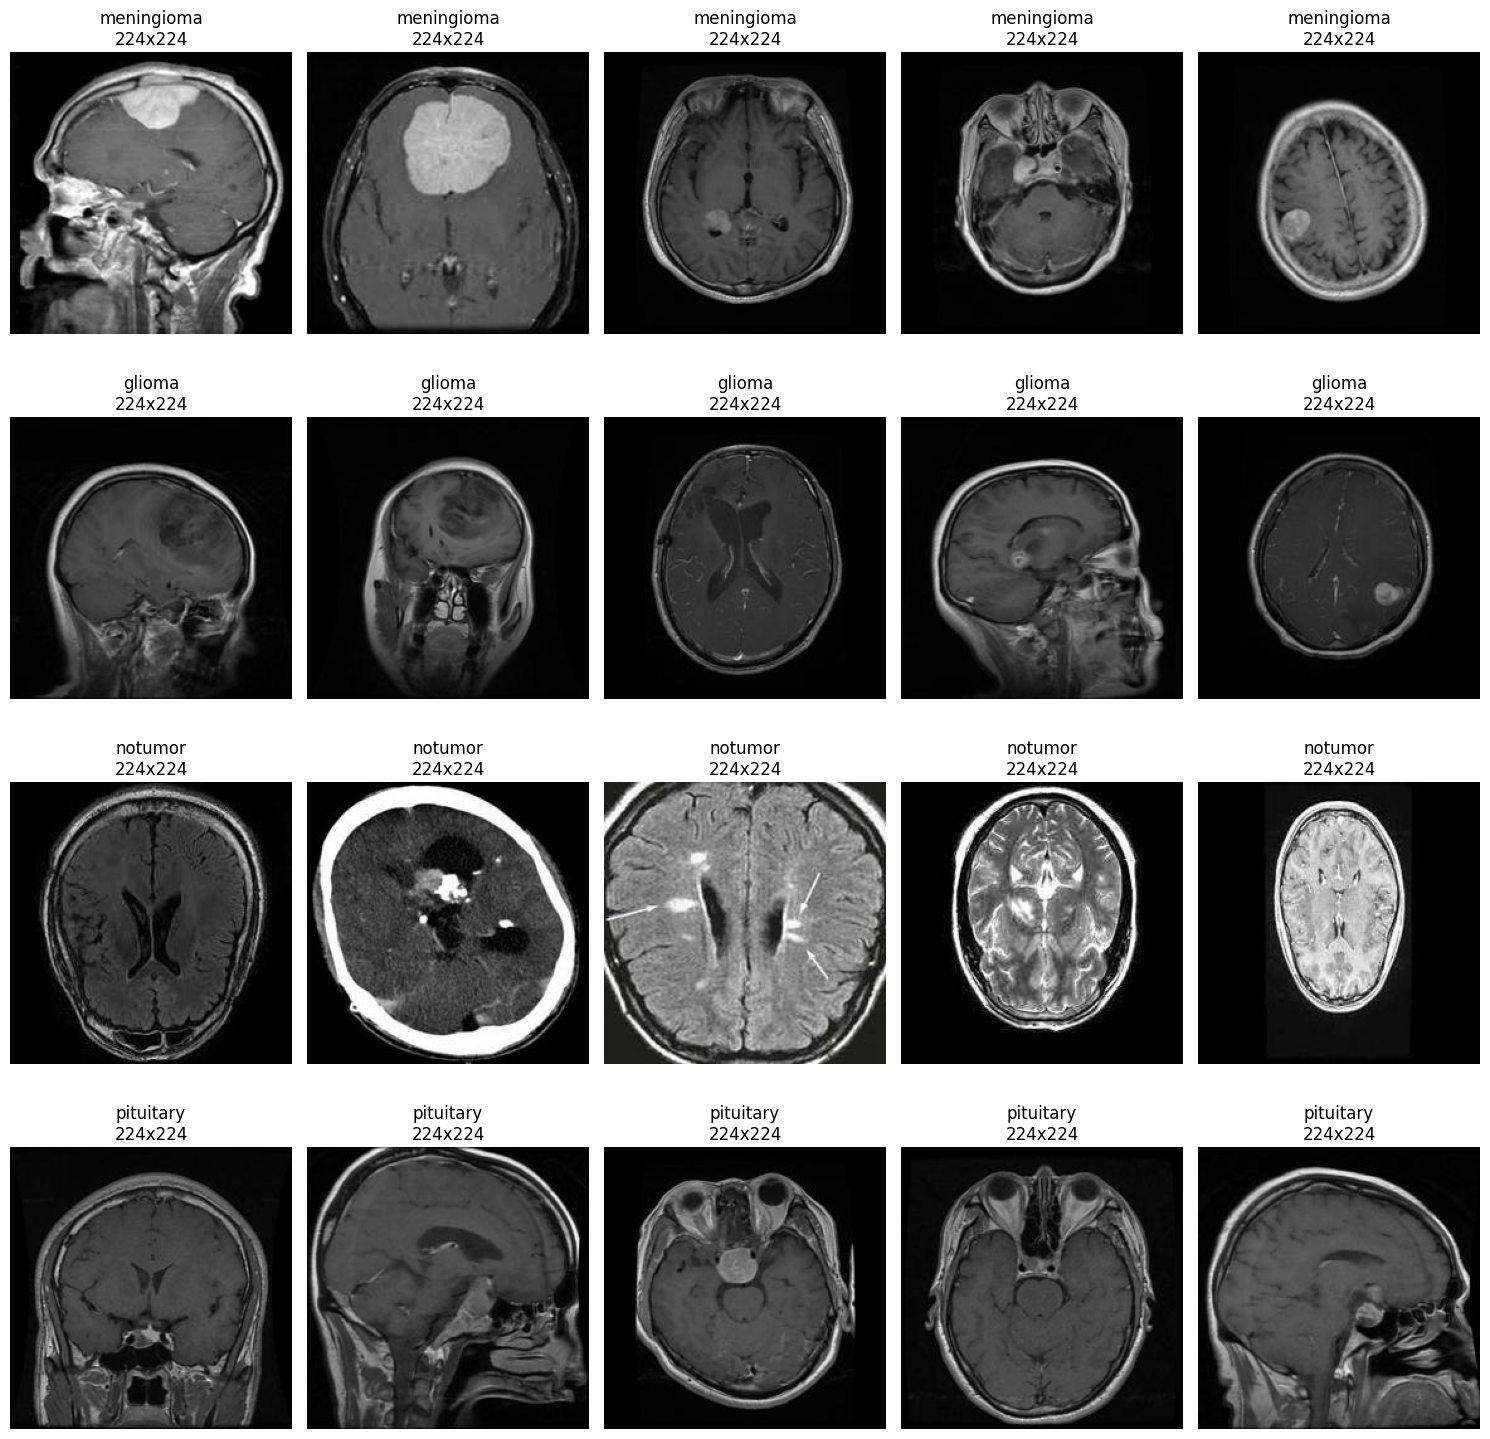

In [ ]:
analyze_distribution("extracted_data/Dataset 2A/Testing")

as we see the visualization is okay but there's an odd thing that is training and testing visualization has the same Red , green and blue this can only mean one thing that each picture r,g,b is the same so lets check it out. Is it true ?

In [ ]:
def count_dominant_colors_with_neutral(directory, tolerance=5):
    color_dominance = defaultdict(lambda: {'Red': 0, 'Green': 0, 'Blue': 0, 'Neutral': 0})

    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if not os.path.isdir(class_dir):
            continue

        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        for file in image_files:
            try:
                img = Image.open(os.path.join(class_dir, file)).convert("RGB")
                img_array = np.array(img)

                r = np.mean(img_array[:, :, 0])
                g = np.mean(img_array[:, :, 1])
                b = np.mean(img_array[:, :, 2])

                if max(abs(r - g), abs(r - b), abs(g - b)) <= tolerance:
                    color_dominance[class_name]['Neutral'] += 1
                else:
                    if r > g and r > b:
                        color_dominance[class_name]['Red'] += 1
                    elif g > r and g > b:
                        color_dominance[class_name]['Green'] += 1
                    elif b > r and b > g:
                        color_dominance[class_name]['Blue'] += 1
            except:
                continue

    df_dominance = pd.DataFrame.from_dict(color_dominance, orient='index')
    print("🎯 Jumlah Gambar yang Didominasi Red, Green, Blue, atau Neutral per Kelas:")
    print(df_dominance)

    df_dominance.plot(kind='bar', stacked=False, figsize=(12, 6),
                      color=['red', 'green', 'blue', 'gray'])
    plt.title('Jumlah Gambar Dominan Warna per Kelas (Termasuk Neutral)')
    plt.xlabel('Kelas')
    plt.ylabel('Jumlah Gambar')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

🎯 Jumlah Gambar yang Didominasi Red, Green, Blue, atau Neutral per Kelas:
            Red  Green  Blue  Neutral
meningioma    0      0     0     1339
glioma        0      0     0     1321
notumor       0      0     0     1595
pituitary     0      0     0     1457


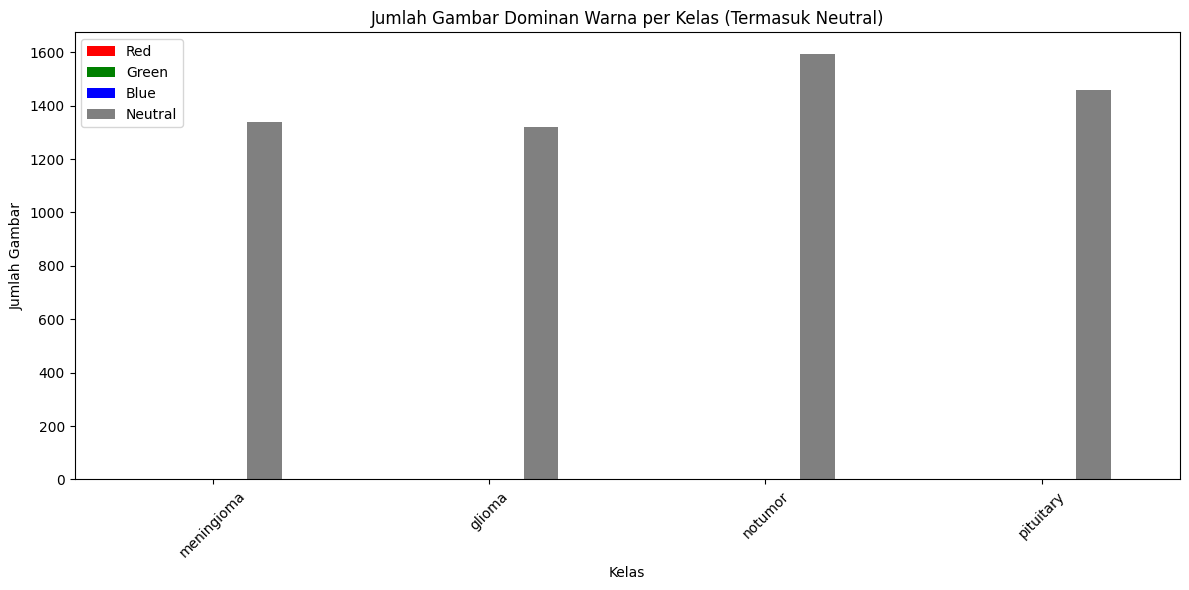

In [ ]:
count_dominant_colors_with_neutral("extracted_data/Dataset 2A/Training")

🎯 Jumlah Gambar yang Didominasi Red, Green, Blue, atau Neutral per Kelas:
            Red  Green  Blue  Neutral
meningioma    0      0     0      306
glioma        0      0     0      300
notumor       0      0     0      405
pituitary     0      0     0      300


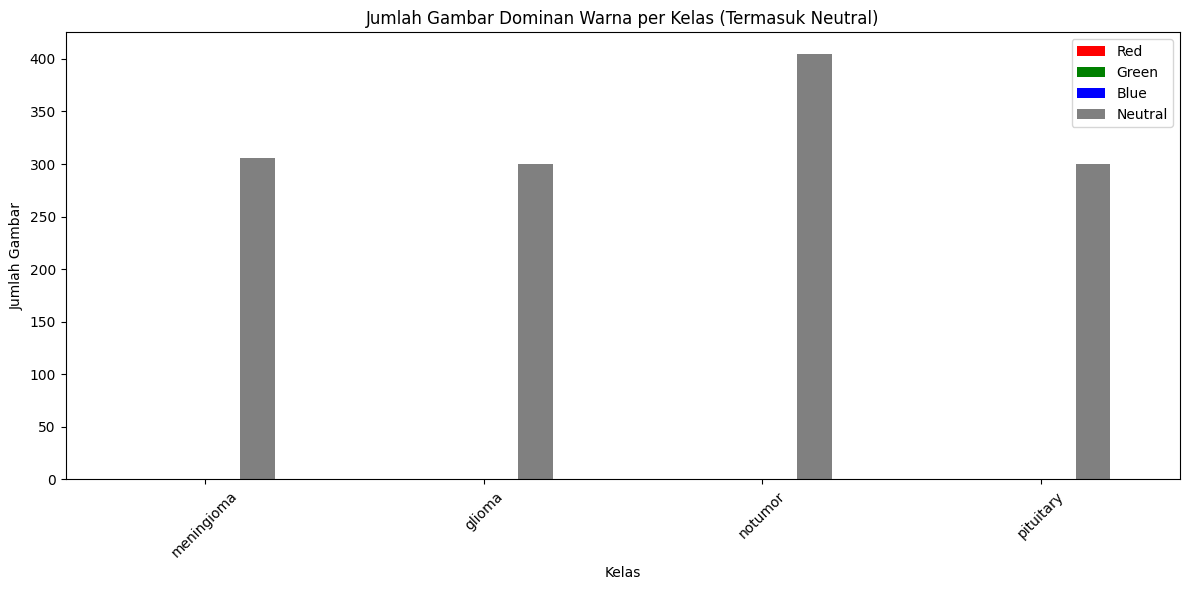

In [ ]:
count_dominant_colors_with_neutral("extracted_data/Dataset 2A/Testing")

it's true that every colour is neutral or can i say it's black. so it's kinda sad that color doesnt impact this case at all because it's using x rays black and white only :" so lets move on to preprocessing.

### Data Augmentation

so here we are gonna do some data augmentation by rotating or flipping the picture this is good for training the dataset, this is good for training so they wont be confused if the image is cropped, rotated, or zoom later in the testing datasets.

In [19]:
def split_train_val(original_train_dir, target_dir, val_ratio=0.15):
    train_dir = os.path.join(target_dir, 'train')
    val_dir = os.path.join(target_dir, 'val')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(original_train_dir):
        class_path = os.path.join(original_train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = os.listdir(class_path)
        random.shuffle(images)

        val_count = int(len(images) * val_ratio)
        val_images = images[:val_count]
        train_images = images[val_count:]

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_dir, class_name, img)
            shutil.copy(src, dst)

        for img in val_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_dir, class_name, img)
            shutil.copy(src, dst)

    print(f"Split kelar, augmenatation dan preprocessing kelar. Train di '{train_dir}', Val di '{val_dir}'")


In [ ]:
split_train_val("extracted_data/Dataset 2A/Training", "extracted_data/Dataset 2A/Splitted", val_ratio=0.15)

Split kelar, augmenatation dan preprocessing kelar. Train di 'extracted_data/Dataset 2A/Splitted/train', Val di 'extracted_data/Dataset 2A/Splitted/val'


# Building The Model

so here's we are building the alexnet, just like the picture, which given in the question. :" help padre my cpu and gpu is dying

Okay for the output im using Softmax, why ? because it is used in machine learning models, especially for multi-class classification. it's good because softmax  turn the raw output values into probabilities. It works by taking these logits, which can be any real number, and converting them into values between 0 and 1, where the sum of all probabilities equals 1. This makes it easier to interpret the model’s output because each value can be seen as the probability of the input belonging to a specific class.

In [ ]:
def build_alexnet(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential([
        layers.Conv2D(96, kernel_size=(11,11), strides=4, activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        layers.Conv2D(256, kernel_size=(5,5), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),

        layers.Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'),

        layers.Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'),

        layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides=2),
        layers.Flatten(),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

so here for the loss ofc we are using categorical crossentropy and for this we only use the accuary metrics first, cause i dont know if my cpu and gpu can hold or not :"

In [ ]:
alexnet_model = build_alexnet()
alexnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
alexnet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,763,396 (178.39 MB)

 Trainable params: 46,763,396 (178.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_ds_small = train_ds.take(100)
val_ds_small = val_ds.take(20)

history_beforetuning = alexnet_model.fit(
    train_ds_small,
    validation_data=val_ds_small,
    epochs=10
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.2923 - loss: 40.9409 - val_accuracy: 0.3750 - val_loss: 1.3425
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.2942 - loss: 1.3452 - val_accuracy: 0.3125 - val_loss: 1.3642
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.3208 - loss: 1.3261 - val_accuracy: 0.3875 - val_loss: 1.2205
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3110 - loss: 1.2877 - val_accuracy: 0.3250 - val_loss: 1.3081
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.3187 - loss: 1.3178 - val_accuracy: 0.2750 - val_loss: 1.3526
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3327 - loss: 1.2637 - val_accuracy: 0.3000 - val_loss: 1.3263
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3241 - loss: 1.3142 - val_accuracy: 0.2625 - val_loss: 1.3137
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3560 - loss: 1.3149 - val_acc

In [37]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(Dataset_path,"Testing"),
    validation_split=None,
    label_mode = "categorical",
    seed=1337,
    image_size=image_size,
    batch_size=1,
)

Found 1311 files belonging to 4 classes.


In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 76s 58ms/step


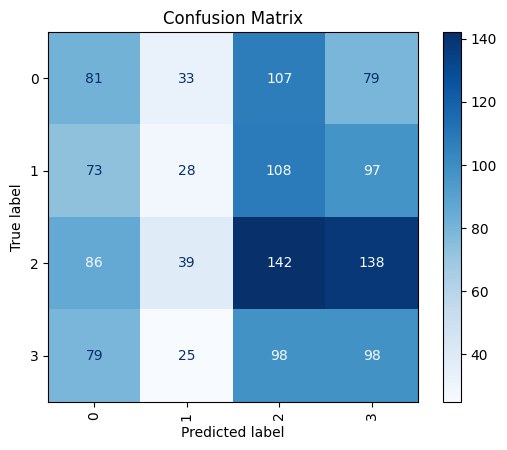

In [ ]:
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
class_names = test_ds.class_names if hasattr(test_ds, 'class_names') else [f"Class {i}" for i in np.unique(y_true)]

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.25      0.27      0.26       300
  meningioma       0.22      0.09      0.13       306
     notumor       0.31      0.35      0.33       405
   pituitary       0.24      0.33      0.28       300

    accuracy                           0.27      1311
   macro avg       0.26      0.26      0.25      1311
weighted avg       0.26      0.27      0.26      1311



### Class-by-Class Breakdown Analysis

1. Glioma
- Precision (0.25): When the model predicts glioma, it’s correct only 25% of the time. Many non-glioma cases are being mislabeled as glioma.
- Recall (0.27): The model detects only 27% of actual glioma cases, missing 73% of them.
- F1-score (0.26): The balance between precision and recall is poor, indicating weak performance for this class.

2. Meningioma
- Precision (0.22): Only 22% of predicted meningiomas are correct; the rest are false positives.
- Recall (0.09): Alarmingly low—the model catches just 9% of actual meningiomas, failing to identify 91%.
- F1-score (0.13): The worst-performing class, likely due to subtle features or data scarcity.
3. No Tumor
- Precision (0.31): The highest among classes, but still low—31% of no tumor predictions are correct.
- Recall (0.35): The model finds 35% of actual non-tumor cases, but 65% are misclassified as tumors.
- F1-score (0.33): Better than other classes but still subpar.
4. Pituitary
- Precision (0.24): Only 24% of pituitary predictions are accurate.
- Recall (0.33): The model identifies 33% of true pituitary cases, leaving 67% undetected.
- F1-score (0.28): Slightly better than glioma/meningioma but still inadequate.

okay so the main point of this interpretations is:

1. Low Recall for Meningioma (9%): The model almost entirely misses this tumor type, which could be critical in medical diagnostics.
2. High False Positives: Low precision across all classes means the model frequently mislabels non-target tumors (e.g., calling a glioma a pituitary tumor).

for this case we're likely going to focus on recall so for the fine tuning will try to get a recall higher bcs if it's classified as another tumor it's still okay then classified as no tumor.

# Modifikasi Model

so for this modified version i added some things:
1. The first one is batch normalization after every layer the main reason is to Stabilizes training by normalizing activations functions and accelerate training. It works by normalizing the activations of each layer, ensuring that the input distributions remain consistent throughout the network. This prevents internal covariate shift, where small changes in earlier layers can amplify and disrupt training in deeper layers. By maintaining stable activations, BatchNorm allows for higher learning rates, reduces sensitivity to weight initialization, and acts as a mild regularizer. This leads to faster convergence and more reliable training, especially in deep networks like AlexNet.initialization.

2. the second one is early stopping, early stopping was implemented to prevent overfitting by monitoring validation loss and halting training when performance stops improving. With a patience of 5 epochs, the model stops early if no progress is made, avoiding unnecessary training time and preserving the best weights before overfitting begins. This acts as an implicit regularization method, ensuring the model generalizes well rather than just memorizing training data. Additionally, it automatically restores the best-performing weights, saving the need for manual checkpoint selection. ( SAVE A LOT OF OUR TIME ) THANKS EARLY STOPPING

3. the third one for our modification is L2 Regularization. I applied L2 Regularization to the first, second, and fifth convolutional layers to penalize excessively large weights. By adding a small penalty (λ = 0.001) to the loss function based on weight magnitudes, the model is discouraged from relying too heavily on any single feature. This prevents overfitting by keeping weights smaller and more balanced, leading to smoother decision boundaries and better generalization. Unlike Dropout, which randomly deactivates neurons, L2 regularization works continuously during training, softly constraining model complexity.

4. Last but not least Learning Rate Reduction callback was used to fine-tune training by dynamically adjusting the learning rate when validation loss plateaus. If no improvement is seen for 3 epochs, the learning rate is reduced by a factor of 0.2 (but never below 1e-6). This allows the model to make large updates early in training for fast convergence, then smaller, more precise updates later for fine-tuning. By adapting the learning rate automatically, it helps escape shallow local minima and improves final model performance without manual intervention. ( make you smarter and i hope faster for the earlystopping to works :) )



In [32]:
def build_modified_alexnet(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential()

    model.add(layers.Conv2D(96, (11, 11), strides=4, padding='valid', activation='relu',
                           input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu',
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                           kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3, 3), strides=2))

    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [33]:
model = build_modified_alexnet(input_shape=(224, 224, 3), num_classes=4)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


also i increase the take to 200 to give more data to train with per each batch.

At first, I used just 100 training samples and 20 validation samples to keep things lightweight and to speed up early testing and debugging. It helped me focus on making sure the code and pipeline worked properly without long training times.

in this tuning, I increased the training set to 200 and the validation set to 40. This gave the model a better chance to learn and generalize while still keeping things efficient.

In [ ]:
train_ds_small = train_ds.batch(200)
val_ds_small = val_ds.batch(40)

history = model.fit(
    train_ds_small,
    steps_per_epoch=len(train_ds_small),
    epochs=10,
    validation_data=val_ds_small,
    validation_steps=len(val_ds_small),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.6279 - loss: 1.7326 - precision: 0.6327 - recall: 0.6102 - val_accuracy: 0.5500 - val_loss: 2.3880 - val_precision: 0.5646 - val_recall: 0.5188 - learning_rate: 1.0000e-04
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.6005 - loss: 1.8665 - precision: 0.6128 - recall: 0.5797 - val_accuracy: 0.6938 - val_loss: 1.3415 - val_precision: 0.7020 - val_recall: 0.6625 - learning_rate: 1.0000e-04
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 335s 2s/step - accuracy: 0.5832 - loss: 1.9787 - precision: 0.5969 - recall: 0.5708 - val_accuracy: 0.8125 - val_loss: 1.1026 - val_precision: 0.8411 - val_recall: 0.7937 - learning_rate: 1.0000e-04
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.5963 - loss: 1.8815 - precision: 0.6150 - recall: 0.5834 - val_accuracy: 0.7750 - val_loss: 1.1601 - val_precision: 0.7771 - val_recall: 0.7625 - learning_rate: 1.0000e-04
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 380s

Although we cut down the train and val ds. for the test data set is still gonna be in full-size. This will provides a more accurate and consistent picture of how well the model generalizes to unseen data. It helps avoid misleading trends that might occur from a small, possibly biased subset. Even with small training data, evaluating on a large, diverse test set ensures that any improvements are meaningful and not due to chance.

In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

1311/1311 ━━━━━━━━━━━━━━━━━━━━ 71s 54ms/step


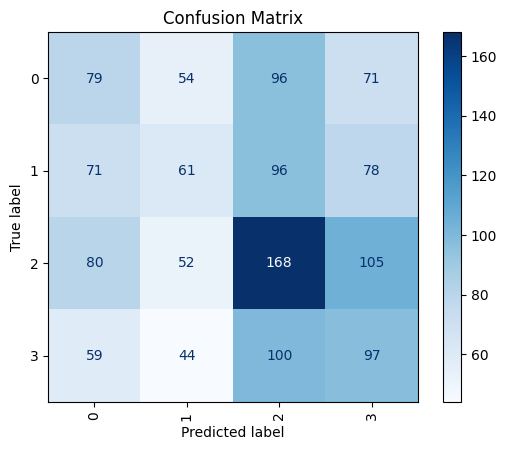

In [ ]:
if len(y_true.shape) > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
class_names = test_ds.class_names if hasattr(test_ds, 'class_names') else [f"Class {i}" for i in np.unique(y_true)]

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.27      0.26      0.27       300
  meningioma       0.29      0.20      0.24       306
     notumor       0.37      0.41      0.39       405
   pituitary       0.28      0.32      0.30       300

    accuracy                           0.31      1311
   macro avg       0.30      0.30      0.30      1311
weighted avg       0.31      0.31      0.30      1311



### Final Comparison Evaluation

so for this classification report and confussion matrix i'll explain for each classes and for each classes will be focusing on recall because this a medical classification which could be dangerous if someone is classify as other starting from
1. Glioma
first is glioma, The recall for glioma dropped slightly by 0.01. This small dip might be due to model adjustments causing a shift in decision boundaries that slightly affected sensitivity to this class. However, the change is minimal, so it likely remains stable overall. for glioma recall it's also 0.01 smaller than it's precision. this is bad actually.
2. Meningioma
meningioma is improved significantly, the score for it's recall doubles.this is likely due to tuning parameters that helped the model better distinguish the features of meningioma from other classes. Initially, the model struggled heavily to recognize this class.
3. Notumor
it's also improved but for no tumor is likely better if we aim precision is higher because in medical its better to describe a no disease as disease than viceverca.
4. Pitutiary
Recall for this class is decreased but still for pitutiary is higher 0.04 from its precision indiciating it's gonna be likely someone that is not pitutiary consider as one then viceversa.

So we can conclude 3 things:
- The biggest gain is with meningioma. Initially, the model almost failed to identify it (only 9% recall), but after tuning, it's now recognizing 20% — still not great, but a major improvement.
- Notumor also improved, likely due to better generalization from increased training samples.
- Glioma and pituitary remained relatively stable, with very slight drops. This often happens when tuning helps other classes more — it’s a trade-off, but overall performance improved.

# THERE'S A SAYING YOU WIN SOME YOU LOSE SOME AND THATS FOR GLIOMA AND PITUTIARY

### ROC CURVE EVALUATION

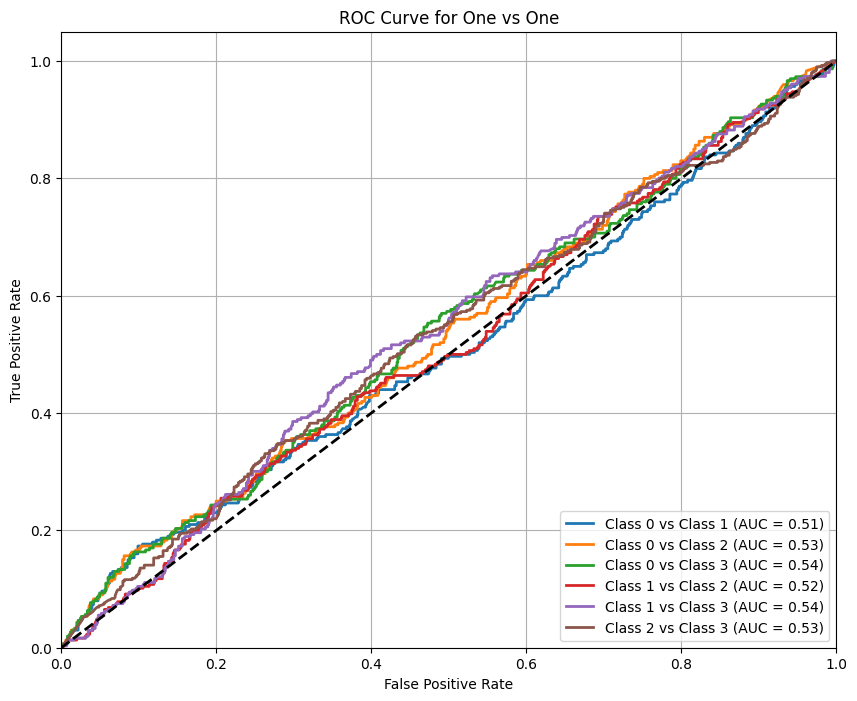

In [43]:
plt.figure(figsize=(10, 8))

for i, j in combinations(range(4), 2):
    y_true_binary = ((y_true == i) | (y_true == j)).astype(int)
    y_true_binary = (y_true == i).astype(int)

    y_pred_binary = y_pred_prob[:, i] - y_pred_prob[:, j]

    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='Class %d vs Class %d (AUC = %0.2f)' % (i, j, roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for One vs One')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

so from the roc curve multiclass we can evaluate per classes, roc curve here is use with technique OVR ( One vs rest ) so we're trying the class with other class. So ROC Curve is use to see is the model confuse or no to detect that is classify to that class or not , so here is an evaluation for each classes:

1. Class 0 (Glioma) vs. Others

AUC 0.51–0.54: The model barely outperforms random guessing (0.5) when distinguishing glioma from other tumors. This aligns with the earlier F1-score of 0.26, confirming that glioma features overlap heavily with other classes (e.g., meningioma or pituitary). The low AUC suggests the model cannot reliably isolate glioma-specific patterns, possibly due to similar visual traits in MRI scans or insufficient training data for this class.

2. Class 1 (Meningioma) vs. Others

AUC 0.51–0.54: Meningioma is the hardest to identify (recall: 20%), and these AUC values reflect its confusion with other classes. The near-random performance implies the model treats meningioma almost like noise—likely because it’s rare, has subtle features, or is mislabeled as "no tumor" or pituitary in your data.

3. Class 2 (No Tumor) vs. Others

AUC 0.52–0.53: The model fails to clearly separate healthy tissue (no tumor) from tumors. This is critical in medical diagnosis, as false positives (mislabeling healthy scans as tumors) waste resources, while false negatives (missing tumors) are dangerous. The low AUC indicates the model lacks confidence in identifying "normal" cases, possibly due to artifacts in scans or imbalanced training data.

4. Class 3 (Pituitary) vs. Others

AUC 0.53–0.54: Slightly better but still poor. Pituitary tumors might share size/location traits with gliomas or meningiomas, causing confusion. The marginally higher AUC (0.54 vs. 0.51 for others) hints that pituitary tumors could have slightly more distinct features, but not enough for reliable diagnosis.

so yup it's bad :" for every classes so i can say it's not the model fault it's because of
1. the model lack of data training because we're only taking 100 each batch so i can say it's need more data for furtherwork and ofc a good gpu and fast. I minimize it because it was taking 6 hours just to finish a normal running model. So yeah if i have more time and better gpu, it could result better.
2. Besides the lackness of data, another point that i want to highlight is Data feature issues that is Overlapping tumor features or poor image quality likely cause the confusion. ( random guessing :" )
3.  another thing that is our model after being tuned is overfit because what i say before it lacks data train so when it does the testing it's getting confused.

# CONCLUSION

sooo for my conclusion i can say that we're focusing on recall because it's a medical case, and we dont want people that is disease is diagnose as not. Although our best effort to make this model, the recall is still low but it's better after we tuned it and we get higher macro recall so that's a good start for now. For furtherworks like i said before, increasing the train data ( taking all not 100 / batch size ) , using better gpu for time efficient, and ofc better hyperparameter tuning cause i dont get to play with the tuning a lot just playing with the normalization,earlystopping , L2 regulazations, but not with the input shape , learning rate , etc. So yeah that's all final words this is not the best model , and it needs furtherworks to improve it.